<a href="https://colab.research.google.com/github/rzagni/Fintech/blob/main/news_vector_store_sp500_zagniA01795457.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**<font color="green">Fintech and Digital Innovation in Finance**</font>
###<font color="green">**Course project part 2 | Semantic search and Vector Database on S&P 500 news**<font>
###<font color="green">**Renzo Zagni A01795457**</font>


# Introduction to vector databases on S&P 500 news

 # 📌 Objectives

 By the end of this notebook, students will be able to:

 1. **Load and Explore Financial News Data:**
    - Load a preprocessed dataset of financial news headlines and summaries related to S&P 500 companies.
    - Inspect and structure relevant metadata including publication date, ticker, and provider.

 2. **Build a Custom Vector Store:**
    - Combine title and summary text for embedding.
    - Implement a vector store from scratch with support for semantic search and optional metadata-based filtering using cosine similarity.

 3. **Generate and Use Sentence Embeddings:**
    - Apply a pre-trained transformer model (all-MiniLM-L6-v2) to encode text into embeddings for semantic analysis.

 4. **Perform Semantic Search with Filtering:**
    - Retrieve the most relevant news documents for a given query using both full-dataset and metadata-filtered searches.

 5. **Analyze Semantic Search Results:**
    - Interpret and visualize results of search queries (e.g., "AI announcement").
    - Identify temporal patterns and ticker frequency among top-ranked results.

 6. **Implement a FAISS-Based Vector Store:**
    - Normalize embeddings and use FAISS (IndexFlatIP) to enable efficient similarity search at scale.
    - Compare FAISS-based search results with custom vector store results.

 7. **Critically Compare Search Systems:**
    - Evaluate differences in similarity computation, speed, and scalability between custom and FAISS-based systems.
    - Reflect on design trade-offs for real-world vector search systems.

## Install and Import important librairies

In [2]:
%pip install sentence-transformers
%pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 129.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 103.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 82.4 MB/s eta 0:00:00


In [1]:
from sentence_transformers import SentenceTransformer
import faiss
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import matplotlib.pyplot as plt
import faiss

In [35]:
# Additional librarties used
import os
import time

In [3]:
#
# Let's hide FutureWarnings...
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Load news data

Load the provided news dataset and inspect the contents.

 👉 **Instructions**:
 - Load the CSV file named df_news.csv into a pandas DataFrame.
 - Convert the PUBLICATION_DATE column to a proper date format (not datetime).
 - Display the first few rows to understand the data structure. The key columns you’ll be using are:
   - TITLE
   - SUMMARY
   - TICKER
   - PROVIDER
   - PUBLICATION_DATE


In [4]:
#
# Connect to G Drive to save and retrieve objects
from google.colab import drive
drive.mount('/content/drive')
working_dir = '/content/drive/MyDrive/MNA/Fintech'

os.chdir(working_dir)
print(f"Working directory: {working_dir}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Working directory: /content/drive/MyDrive/MNA/Fintech


In [5]:
# df_news.csv was loaded in google drive under {working_dir}
df_news = pd.read_csv('df_news.csv')
df_news['PUBLICATION_DATE'] = pd.to_datetime(df_news['PUBLICATION_DATE']).dt.date
display(df_news)

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,PROVIDER,URL
0,MMM,2 Dow Jones Stocks with Promising Prospects an...,The Dow Jones (^DJI) is made up of 30 of the m...,2025-05-29,StockStory,https://finance.yahoo.com/news/2-dow-jones-sto...
1,MMM,3 S&P 500 Stocks Skating on Thin Ice,The S&P 500 (^GSPC) is often seen as a benchma...,2025-05-27,StockStory,https://finance.yahoo.com/news/3-p-500-stocks-...
2,MMM,3M Rises 15.8% YTD: Should You Buy the Stock N...,"MMM is making strides in the aerospace, indust...",2025-05-22,Zacks,https://finance.yahoo.com/news/3m-rises-15-8-y...
3,MMM,Q1 Earnings Roundup: 3M (NYSE:MMM) And The Res...,Quarterly earnings results are a good time to ...,2025-05-22,StockStory,https://finance.yahoo.com/news/q1-earnings-rou...
4,MMM,3 Cash-Producing Stocks with Questionable Fund...,While strong cash flow is a key indicator of s...,2025-05-19,StockStory,https://finance.yahoo.com/news/3-cash-producin...
...,...,...,...,...,...,...
4866,ZTS,2 Dividend Stocks to Buy With $500 and Hold Fo...,Zoetis is a leading animal health company with...,2025-05-23,Motley Fool,https://www.fool.com/investing/2025/05/23/2-di...
4867,ZTS,Zoetis (NYSE:ZTS) Declares US$0.50 Dividend Pe...,Zoetis (NYSE:ZTS) recently affirmed a dividend...,2025-05-22,Simply Wall St.,https://finance.yahoo.com/news/zoetis-nyse-zts...
4868,ZTS,Jim Cramer on Zoetis (ZTS): “It Does Seem to B...,We recently published a list of Jim Cramer Tal...,2025-05-21,Insider Monkey,https://finance.yahoo.com/news/jim-cramer-zoet...
4869,ZTS,Zoetis (ZTS) Upgraded to Buy: Here's Why,Zoetis (ZTS) might move higher on growing opti...,2025-05-21,Zacks,https://finance.yahoo.com/news/zoetis-zts-upgr...


## Implement custom vector store

You will now implement a basic vector store from scratch. This class will allow you to:
1. Store embedded text and metadata.
2. Perform filtered semantic search using cosine similarity.

 👉 **Instructions**:

### Step 1: Prepare Documents
 - Combine the TITLE and SUMMARY columns into a single column named EMBEDDED_TEXT.
 - This combined text will be embedded later.

### Step 2: Load Embedding Model
 - Load the 'all-MiniLM-L6-v2' model from sentence-transformers.

### Step 3: Define CustomVectorStore Class
 Implement the class with the following methods (functions):

 - '__init__': Accepts an embedding model, list of documents, and corresponding metadata. Computes and stores embeddings for all documents.
 - search: Takes a query and returns the top k most similar documents, optionally filtered using metadata.
   - If a metadata_filter function is provided, apply it before computing similarity.
   - Use cosine similarity to compute distances.
   - Return the top k results as tuples of: (document, metadata, similarity score).

 ✅ **Requirements**:
 - Ensure the number of documents matches the number of metadata entries.
 - Make use of sklearn.metrics.pairwise.cosine_similarity.

You will test your class at the end.

In [6]:
#
# Combine the TITLE and SUMMARY columns into a single column named EMBEDDED_TEXT.
df_news['EMBEDDED_TEXT'] = df_news['TITLE'].fillna('') + " " + df_news['SUMMARY'].fillna('')


In [7]:
#
# Loading the pre-trained embedding model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [20]:
#
# Define reusable function
def display_search_results(results):
    """
    Print search results with metadata and similarity scores.

    Args:
        results (list): Each item is a tuple of (doc, meta, score).
    """
    for i, (doc, meta, score) in enumerate(results, 1):
        print(f"\nResult {i}")
        print("-" * len(f"Result {i}"))
        print(f"Ticker: {meta['TICKER']}")
        print(f"Publication Date: {meta['PUBLICATION_DATE']}")
        print(f"Provider: {meta['PROVIDER']}")
        print(f"Similarity Score: {score:.4f}")
        print(f"Document: {doc}\n")


In [9]:
#
# Define CustomVectorStore Class
class CustomVectorStore:
    """
    An in-memory vector store for semantic search using sentence-transformers.

    Attributes:
        embedding_model: A SentenceTransformer model used for embedding texts.
        documents: A list of original document texts.
        metadata: A list of metadata dictionaries corresponding to each document.
        embeddings: Numpy array of document embeddings.
    """
    def __init__(self, embedding_model, documents, metadata):
        assert len(documents) == len(metadata), "Documents and metadata must be the same length."

        self.embedding_model = embedding_model
        self.documents = documents
        self.metadata = metadata
        self.embeddings = embedding_model.encode(documents, show_progress_bar=True)

    def search(self, query, k=5, metadata_filter=None):
        #
        # Apply metadata filter if provided
        if metadata_filter:
            filtered_indices = [i for i, meta in enumerate(self.metadata) if metadata_filter(meta)]
            if not filtered_indices:
                return []

            filtered_embeddings = [self.embeddings[i] for i in filtered_indices]
            filtered_documents = [self.documents[i] for i in filtered_indices]
            filtered_metadata = [self.metadata[i] for i in filtered_indices]
        else:
            filtered_embeddings = self.embeddings
            filtered_documents = self.documents
            filtered_metadata = self.metadata
        #
        # Embed the query
        query_embedding = self.embedding_model.encode([query])

        #
        # Compute distances
        similarities = cosine_similarity(query_embedding, filtered_embeddings)[0]

        #
        # Get top k results
        top_indices = np.argsort(similarities)[::-1][:k]
        results = [(filtered_documents[i], filtered_metadata[i], similarities[i]) for i in top_indices]
        return results


## Create and populate the vector store

 👉 **Instructions**:
 - Convert the combined EMBEDDED_TEXT column into a list of strings.
 - Create a metadata list of dictionaries for each document with keys:
   - 'PUBLICATION_DATE'
   - 'TICKER'
   - 'PROVIDER'
 - Instantiate your CustomVectorStore using:
   - The embedding model.
   - The list of document strings.
   - The metadata list.

 After initializing the store, you should be able to perform searches using:
'store.search("Apple earnings", k=3)'


In [33]:
#
# Convert the combined EMBEDDED_TEXT column into a list of strings.
documents = df_news['EMBEDDED_TEXT'].tolist()

#
# Create a metadata list of dictionaries for each document with keys
metadata = df_news[['PUBLICATION_DATE', 'TICKER', 'PROVIDER']].to_dict(orient='records')

#
# Instantiate CustomVectorStore
custom_store = CustomVectorStore(
    embedding_model=model,
    documents=documents,
    metadata=metadata
)

#
# Perform searches using: 'store.search("Apple earnings", k=3)'
results = custom_store.search("Apple earnings", k=3)

#
# Print the results
display_search_results(results)


Batches:   0%|          | 0/153 [00:00<?, ?it/s]


Result 1
--------
Ticker: APTV
Publication Date: 2025-05-01
Provider: Barrons.com
Similarity Score: 0.5717
Document: Aptiv Stock Rises. Earnings Were Great, But Tariff Impact Is Still Uncertain. Thursday morning, Aptiv reported first-quarter earnings per share of $1.69 from sales of $4.8 billion in sales. Wall Street was looking for EPS of $1.53 from sales of $4.8 billion.


Result 2
--------
Ticker: OKE
Publication Date: 2025-04-30
Provider: Simply Wall St.
Similarity Score: 0.5701
Document: ONEOK (NYSE:OKE) Reports Q1 2025 Revenue Surge to US$8 Billion ONEOK (NYSE:OKE) recently released its first-quarter earnings, reporting revenue of USD 8,043 million, a marked increase year-over-year, but a minor dip in net income and earnings per share. Alongside this, the company reaffirmed its quarterly dividend of $1.03 per share. These updates coincide with a 4.5% price increase over the week, which aligns with broader market gains of 5.2%. Despite fluctuations in major indices due to economi

## Using your vector store and analyzing the results

### Retrieve AI Announcements

 Now that your vector store is working, let's use it to retrieve relevant documents.

 👉 **Instructions**:
 - Perform a semantic search using the query `"AI announcement"` with `k=50` to retrieve the top 50 most relevant articles.
 - Display each result's:
   - `TICKER`
   - `PUBLICATION_DATE`
   - `PROVIDER`
   - Similarity score
   - Full document text


In [34]:
#
# Perform semantic search  using the query "AI announcement" with k=50
results = custom_store.search("AI announcement", k=50)

#
# Display the results
display_search_results(results)



Result 1
--------
Ticker: ADBE
Publication Date: 2025-05-27
Provider: Investor's Business Daily
Similarity Score: 0.5567
Document: AI Stocks Face 'Show Me' Moment. Nvidia Earnings Due With China In Focus. Amid hype over artificial intelligence, the best AI stocks generate revenue or get a strategic edge from the fast evolving technology.


Result 2
--------
Ticker: JKHY
Publication Date: 2025-03-17
Provider: Insider Monkey
Similarity Score: 0.5467
Document: Jack Henry (JKHY) Integrates AI-Driven Lending Tech With Algebrik We recently published a list of 12 AI News Investors Should Not Miss This Week. In this article, we are going to take a look at where Jack Henry & Associates, Inc. (NASDAQ:JKHY) stands against other AI news Investors should not miss this week. Artificial Intelligence (AI) is known to increase productivity, decrease human error, […]


Result 3
--------
Ticker: PLTR
Publication Date: 2025-05-31
Provider: Motley Fool
Similarity Score: 0.5353
Document: Better Artificial 

 ### **Q1.** What are the top companies (by TICKER) most frequently appearing in the top 50 search results for the query "AI announcement"?  
 Check their company names on Yahoo Finance. Are you surprised by the results?

 ✅ **Your task**:
 - Count the number of times each TICKER appears.
 - Print and analyze the top results.

In [12]:
#
# Count the number of times each TICKER appears.
tickers = [meta['TICKER'] for _, meta, _ in results]
ticker_counts = Counter(tickers)

#
# print the results
print("Top tickers by frequency in top 50 AI-related results:\n")
for ticker, count in ticker_counts.most_common():
    suffix = "time" if count == 1 else "times"
    print(f"{ticker}: {count} {suffix}")


Top tickers by frequency in top 50 AI-related results:

PLTR: 5 times
BKR: 3 times
AMD: 3 times
CTSH: 3 times
QCOM: 2 times
META: 2 times
AMZN: 2 times
MSFT: 2 times
EXPE: 2 times
INTC: 2 times
ADBE: 1 time
JKHY: 1 time
WSM: 1 time
RSG: 1 time
CEG: 1 time
SMCI: 1 time
ORCL: 1 time
GOOG: 1 time
GOOGL: 1 time
INTU: 1 time
NVDA: 1 time
YUM: 1 time
ABNB: 1 time
PYPL: 1 time
NFLX: 1 time
CRM: 1 time
ROK: 1 time
CSCO: 1 time
NOW: 1 time
HPQ: 1 time
DELL: 1 time
FFIV: 1 time
IT: 1 time
KMX: 1 time


<font color="green"> **Analysis of Top Results:**</font>

<font color="green">The list of top tickers in the AI announcement search shows both expected and surprising companies. Palantir (PLTR) appears the most, showing how often it connects itself with AI in the news, even more than Big Tech companies. This reflects Palantir’s strong focus on promoting its AI capabilities, especially in defense and data analytics.</font>

<font color="green">Big names like AMD, Intel, Microsoft, Meta, Amazon, and Google also appear, though less frequently. These companies are deeply involved in AI, making chips, building large models, and offering AI-powered tools. Their lower count likely reflects fewer press mentions under this specific query.</font>

<font color="green">Some unexpected names show up too. Baker Hughes, an energy company, likely appears because of AI use in operations. Cognizant and Expedia suggest that AI is being used in IT services and travel. Others like Yum! Brands and Williams-Sonoma show AI is spreading into retail and food sectors.</font>


### **Q2.** What is the date range of the top 50 results? Are the articles evenly distributed across time?

 ✅ **Your task**:
 - Extract the publication dates of the top 50 results.
 - Plot a histogram to visualize the temporal distribution.
 - Reflect: Are these mentions clustered in recent months or spread evenly?

 🧠 **Follow-up**: What could explain the timing of increased AI announcements?

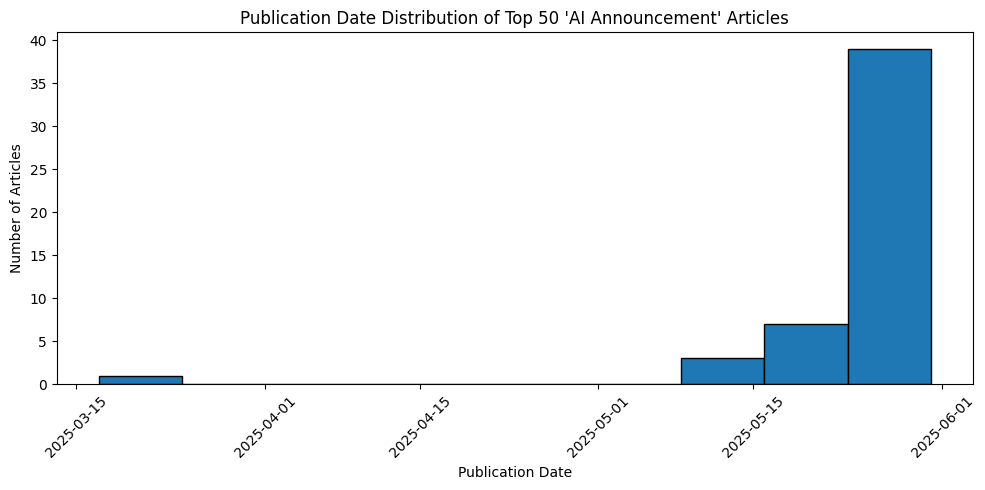

Date Range => From 2025-03-17 to 2025-05-31


In [13]:

#
# Extract publication dates from the top 50 results
dates = [meta['PUBLICATION_DATE'] for _, meta, _ in results]

#
# Convert to datetime
date_series = pd.to_datetime(dates)

#
# Plot histogram
plt.figure(figsize=(10, 5))
plt.hist(date_series, bins=10, edgecolor='black')
plt.title("Publication Date Distribution of Top 50 'AI Announcement' Articles")
plt.xlabel("Publication Date")
plt.ylabel("Number of Articles")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#
# Print date range
print(f"Date Range => From {date_series.min().date()} to {date_series.max().date()}")


**Are these mentions clustered in recent months or spread evenly?**

<font color="green">The histogram shows that the publication dates are highly clustered in recent months, specially in the second half of May 2025. There is a high increase in the number of articles during this period, while earlier months like March and April have little to no activity. </font>

**What could explain the timing of increased AI announcements?**

<font color="green"> This concentration of announcements can be explained by several factors. One major reason could be the corporate earnings season—many companies release their first-quarter results in April and May, often using the opportunity to highlight new AI initiatives to impress investors. Another likely reason is the timing of major tech events, such as Google I/O, Microsoft Build, or other AI-focused conferences, which typically occur around the same time and serve as platforms for big announcements. </font>

<font color="green">Additionally, as AI continues to dominate headlines, companies may feel pressure to publicly align themselves with the trend, resulting in a wave of press releases and product launches within the same period. Overall, the timing reflects both strategic communication choices and broader industry cycles.</font>


## Implement FAISS vector store

 We’ll now implement a **FAISS-based vector store**, designed for efficient similarity search at scale.

 👉 **Steps**:
 - Use the same sentence transformer model: all-MiniLM-L6-v2.
 - Encode your text into embessings
 - Normalize the vectors.

 FAISS supports multiple similarity types. For cosine similarity, we must:

 ✅ Normalize vectors to unit length  
 ✅ Use `IndexFlatIP` (inner product), because:
 - For normalized vectors, inner product = cosine similarity


In [14]:
#
# Encode your text into embessings
embeddings = model.encode(documents, show_progress_bar=True, convert_to_numpy=True)
#
#  Normalize the vectors
embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)


Batches:   0%|          | 0/153 [00:00<?, ?it/s]

We’ll now:
 - Initialize the FAISS index
 - Add the document embeddings

In [15]:
dim = embeddings.shape[1]

#
# Use IndexFlatIP (inner product), because: For normalized vectors, inner product = cosine similarity
# Initialize the FAISS index
index = faiss.IndexFlatIP(dim)

#
# Add the document embeddings
index.add(embeddings)

### Create a `FaissVectorStore` class with a `.search()` method.

 This method:
 - Encodes and normalizes the query
 - Optionally applies metadata filters
 - Returns top `k` results with similarity scores and metadata

In [16]:
class FaissVectorStore:
    """
    A FAISS-based vector store for  cosine similarity search with metadata filtering.
    """

    def __init__(self, embedding_model, documents, metadata):

        assert len(documents) == len(metadata), "Documents and metadata must be the same length."

        self.embedding_model = embedding_model
        self.documents = documents
        self.metadata = metadata

        #
        # Embed and normalize
        self.embeddings = self.embedding_model.encode(documents, convert_to_numpy=True, show_progress_bar=True)
        self.embeddings = self.embeddings / np.linalg.norm(self.embeddings, axis=1, keepdims=True)

        #
        # Build FAISS index (cosine similarity via inner product)
        dim = self.embeddings.shape[1]
        self.index = faiss.IndexFlatIP(dim)
        self.index.add(self.embeddings)

    def search(self, query, k=5, metadata_filter=None):

        query_embedding = self.embedding_model.encode([query], convert_to_numpy=True)
        query_embedding = query_embedding / np.linalg.norm(query_embedding, axis=1, keepdims=True)

        #
        # If no filter, search entire index
        if metadata_filter is None:
            scores, indices = self.index.search(query_embedding, k)
            results = [(self.documents[i], self.metadata[i], scores[0][j]) for j, i in enumerate(indices[0])]
            return results
        #
        # Filter metadata
        filtered_indices = [i for i, meta in enumerate(self.metadata) if metadata_filter(meta)]

        if not filtered_indices:
            return []

        #
        # Prepare filtered subset
        filtered_embeddings = self.embeddings[filtered_indices]
        sub_index = faiss.IndexFlatIP(filtered_embeddings.shape[1])
        sub_index.add(filtered_embeddings)

        scores, sub_indices = sub_index.search(query_embedding, k)
        results = [(self.documents[filtered_indices[i]], self.metadata[filtered_indices[i]], scores[0][j])
                   for j, i in enumerate(sub_indices[0])]
        return results


 Let’s run a semantic search using FAISS:
 - Query: `"AI announcement"`
 - Top results: `k=50`

 Print out:
 - Ticker
 - Publication date
 - Provider
 - Cosine similarity score
 - Full text

In [17]:
# Load embedding model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Instantiate FaissVectorStore
faiss_store = FaissVectorStore(
    embedding_model=model,
    documents=documents,
    metadata=metadata
)


Batches:   0%|          | 0/153 [00:00<?, ?it/s]

In [24]:
#
# Run semantic search
results = faiss_store.search("AI announcement", k=50)

#
# Display the results
print("Top 50 Semantic Search Results for 'AI announcement':")
print("====================================================")
display_search_results(results)


Top 50 Semantic Search Results for 'AI announcement':

Result 1
--------
Ticker: ADBE
Publication Date: 2025-05-27
Provider: Investor's Business Daily
Similarity Score: 0.5567
Document: AI Stocks Face 'Show Me' Moment. Nvidia Earnings Due With China In Focus. Amid hype over artificial intelligence, the best AI stocks generate revenue or get a strategic edge from the fast evolving technology.


Result 2
--------
Ticker: JKHY
Publication Date: 2025-03-17
Provider: Insider Monkey
Similarity Score: 0.5467
Document: Jack Henry (JKHY) Integrates AI-Driven Lending Tech With Algebrik We recently published a list of 12 AI News Investors Should Not Miss This Week. In this article, we are going to take a look at where Jack Henry & Associates, Inc. (NASDAQ:JKHY) stands against other AI news Investors should not miss this week. Artificial Intelligence (AI) is known to increase productivity, decrease human error, […]


Result 3
--------
Ticker: PLTR
Publication Date: 2025-05-31
Provider: Motley Fool

## Evaluation: Comparing FAISS Vector Store with your Custom Vector Store

### Retrieval Comparison Across Systems

 👉 **Instructions**:

 - Using the 5 'test_queries' provided in the list below, retrieve the top 5 news for each query using both your custom and FAISS vector stores.
 - Inspect how similar the returned news texts are for each query.
 - Focus especially on the order of results (not just their presence).


In [23]:
test_queries = [
    'Stock price drop',
    'Layoffs',
    'Mergers and acquisitions',
    'Fed interest rate',
    'Regulation',
    'Cryptocurrency'

]

In [32]:
#
# define variable to manage escape codes to improve readabilty
bbold = "\033[1m"
ebold = "\033[0m"

test_queries = [
    "AI announcement",
    "stock dividend increase",
    "quarterly earnings report",
    "merger and acquisition",
    "market outlook for tech stocks"
]

for query in test_queries:

    query_len = len(query)
    print(f"QUERY: '{query}'")
    print("="* (9 + query_len))

    # Results from CustomVectorStore
    custom_results = custom_store.search(query, k=5)
    print(f"\n{bbold}***Custom Vector Store Results:***\n{ebold}")
    display_search_results(custom_results)

    # Results from FaissVectorStore
    faiss_results = faiss_store.search(query, k=5)
    print(f"\n{bbold}***FAISS Vector Store Results:***\n{ebold}")
    display_search_results(faiss_results)
    print("\n")

QUERY: 'AI announcement'

***Custom Vector Store Results:***


Result 1
--------
Ticker: ADBE
Publication Date: 2025-05-27
Provider: Investor's Business Daily
Similarity Score: 0.5567
Document: AI Stocks Face 'Show Me' Moment. Nvidia Earnings Due With China In Focus. Amid hype over artificial intelligence, the best AI stocks generate revenue or get a strategic edge from the fast evolving technology.


Result 2
--------
Ticker: JKHY
Publication Date: 2025-03-17
Provider: Insider Monkey
Similarity Score: 0.5467
Document: Jack Henry (JKHY) Integrates AI-Driven Lending Tech With Algebrik We recently published a list of 12 AI News Investors Should Not Miss This Week. In this article, we are going to take a look at where Jack Henry & Associates, Inc. (NASDAQ:JKHY) stands against other AI news Investors should not miss this week. Artificial Intelligence (AI) is known to increase productivity, decrease human error, […]


Result 3
--------
Ticker: PLTR
Publication Date: 2025-05-31
Provider: Mot

In [36]:
#
# Let's compare performance by measuring execution time

start_custom = time.time()
for query in test_queries:
    custom_results = custom_store.search(query, k=5)
end_custom = time.time()
custom_duration = end_custom - start_custom

start_faiss = time.time()
for query in test_queries:
    faiss_results = faiss_store.search(query, k=5)
end_faiss = time.time()
faiss_duration = end_faiss - start_faiss

# Print results
print(f"\n{bbold}Execution Time Summary:{ebold}")
print(f"Custom Vector Store Total Time: {custom_duration:.4f} seconds")
print(f"FAISS Vector Store Total Time:  {faiss_duration:.4f} seconds")



Execution Time Summary:
Custom Vector Store Total Time: 0.0871 seconds
FAISS Vector Store Total Time:  0.0442 seconds


### **Q3.** Do you observe any significant differences in the top-5 retrieved results for each query between the two systems? Explain why these differences may or may not occur.

<font color="green"> For each of the five test queries, the results from the Custom Vector Store and the FAISS Vector Store were exactly the same. Both returned the same top five articles in the same order, with matching company tickers, publication dates, news sources, and similarity scores. This shows that the two systems are producing identical results for these queries.</font>

<font color="green">This outcome is expected because both systems use the same sentence embedding model (sentence-transformers/all-MiniLM-L6-v2). Additionally, both systems use cosine similarity to compare vectors. Even though FAISS is designed for high-performance search in large datasets, in this small-scale example, it returns the same results as the custom store.</font>

<font color="green">In terms of performance, there is a clear difference in speed. When all five queries were run, the Custom Vector Store took 0.0871 seconds, while the FAISS Vector Store took only 0.0442 seconds. That means FAISS was almost  2x faster. This speed difference may seem small in the example, but it becomes much more important as the number of documents increases.</font>

## Evaluation: Comparing 2 embedding models with your Custom Vector Store

 👉 **Instructions**:

 - Implement your custom vector store with `'all-MiniLM-L6-v2'` model from `sentence-transformers`, and compare it with the `'all-mpnet-base-v2'` model from `sentence-transformers`.
 - Similarly, retrieve the top 5 news for each query using both implementations.
 - Inspect how similar the returned news texts are for each query.
 - Focus especially on the order of results (not just their presence).

In [37]:
# Loading the pre-trained embedding model all-mpnet-base-v2
model_all_mpnet_base_v2 = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [38]:
#
# Instantiate CustomVectorStore with all-mpnet-base-v2 model
custom_store_all_mpnet_base_v2 = CustomVectorStore(
    embedding_model=model_all_mpnet_base_v2,
    documents=documents,
    metadata=metadata
)

Batches:   0%|          | 0/153 [00:00<?, ?it/s]

In [39]:
#
# Comparing output of custom vector store with the two embedded models
for query in test_queries:

    query_len = len(query)
    print(f"QUERY: '{query}'")
    print("="* (9 + query_len))

    # Results from CustomVectorStore
    custom_results = custom_store.search(query, k=5)
    print(f"\n{bbold}***Custom Vector Store Results with all-MiniLM-L6-v2 Model :***\n{ebold}")
    display_search_results(custom_results)

    # Results from FaissVectorStore
    all_mpnet_base_v2_results = custom_store_all_mpnet_base_v2.search(query, k=5)
    print(f"\n{bbold}***Custom Vector Store Results with all-mpnet-base-v2 Model :***\n{ebold}")
    display_search_results(all_mpnet_base_v2_results)
    print("\n")

QUERY: 'AI announcement'

***Custom Vector Store Results with all-MiniLM-L6-v2 Model :***


Result 1
--------
Ticker: ADBE
Publication Date: 2025-05-27
Provider: Investor's Business Daily
Similarity Score: 0.5567
Document: AI Stocks Face 'Show Me' Moment. Nvidia Earnings Due With China In Focus. Amid hype over artificial intelligence, the best AI stocks generate revenue or get a strategic edge from the fast evolving technology.


Result 2
--------
Ticker: JKHY
Publication Date: 2025-03-17
Provider: Insider Monkey
Similarity Score: 0.5467
Document: Jack Henry (JKHY) Integrates AI-Driven Lending Tech With Algebrik We recently published a list of 12 AI News Investors Should Not Miss This Week. In this article, we are going to take a look at where Jack Henry & Associates, Inc. (NASDAQ:JKHY) stands against other AI news Investors should not miss this week. Artificial Intelligence (AI) is known to increase productivity, decrease human error, […]


Result 3
--------
Ticker: PLTR
Publication D

### **Q4.**  Which embedding model performs better in retrieving relevant documents for the queries? Support your answer with specific examples from the results.

<font color="green">Both models found relevant documents, but the quality and focus of the results varied based on the query.</font>

<font color="green">For the query AI announcement, the MiniLM model returned articles directly related to well-known AI companies. For example, it retrieved an article about Adobe discussing AI stock performance and another about Palantir’s AI platform and its growth in 2025. These match the query closely because they describe real announcements from companies involved in AI. On the other hand, the mpnet model returned broader topics, such as a quote from the CEO of Republic Services saying AI is “wildly oversold,” and an article about Dell and HP discussing AI computers. While still related to AI, these results are more general and less announcement-focused. This suggests MiniLM gave more accurate matches for this specific query.</font>

F<font color="green">or stock dividend increase, the mpnet model performed slightly better. It returned a diverse set of companies such as Nasdaq (NDAQ), Otis (OTIS), Paychex (PAYX), and Equifax (EFX), all with specific dividend changes. While the MiniLM model also found strong results, like LyondellBasell (LYB) and VICI Properties (VICI), mpnet covered more ground and identified a broader range of relevant dividend updates.</font>

<font color="green">In the case of quarterly earnings report, MiniLM again provided better results. It retrieved articles clearly focused on Q1 earnings from companies like Campbell Soup (CPB), CF Industries (CF), and Aptiv (APTV), including specific dates and revenue estimates. In contrast, the mpnet model returned more general summaries, like commentary on GE Healthcare and Humana’s earnings, which were less directly tied to earnings reports. This shows MiniLM’s strength in retrieving precise financial news.</font>

<font color="green">For merger and acquisition, MiniLM found targeted results such as the merger between Synopsys (SNPS) and Ansys (ANSS), and Capital One's (COF) Discover deal. These directly address M\&A activity. The mpnet model returned more speculative content, like Citigroup’s acquisition watchlist or Kraft Heinz exploring future deals. While still relevant, these results were not as grounded in concrete M\&A events. MiniLM performed better by surfacing confirmed transactions.</font>

<font color="green">Lastly, for market outlook for tech stocks, the mpnet model showed an advantage. It included rich content like Dell’s earnings forecast and company-specific market strategies, along with broad market trends. MiniLM returned good articles as well, including one from Simply Wall St. about high-growth tech stocks, but mpnet’s results included more detail and forward-looking analysis. This made them more informative for a market outlook question.</font>

<font color="green">Conclusion, MiniLM seems to performs better when the query requires clear, factual answers—like earnings announcements or mergers. Mpnet is better at understanding broad or nuanced queries, offering deeper and more varied results when the topic is more general, such as market trends or investment strategies.</font>


## 🛠️ Implementation-Level Questions

### **Q5.**  What role does vector normalization play in each implementation?


<font color="green">Vector normalization is an important step in making sure both the Custom Vector Store and the FAISS Vector Store return good results when comparing text.</font>

<font color="green">In the Custom Vector Store, normalization is done automatically. This happens because the `cosine_similarity` function from the sklearn library normalize the vectors before comparing them. This is important because cosine similarity cares about the direction of the vectors, not their magnitude. So even if two pieces of text are very similar in meaning but one has a bigger vector, the similarity score won’t be impacted if they’re both normalized.</font>

<font color="green">In the FAISS Vector Store, normalization is not automatic and we had to do it outselves. FAISS uses inner product to compare vectors. To ensure inner product works like cosine similarity, we need to normalize all vectors before adding them to the index and also before searching. If we didn't use normalization, FAISS might favor longer vectors, which can give poor results.</font>

<font color="green">In our case, since both vector stores gave the same results, that means normalization was correctly applied to the FAISS vectors too. This made sure both systems were comparing the meaning of the texts in the same way. </font>




### **Q6.**  What would happen if vectors were not normalized before indexing?

<font color="green">If vectors are not normalized before indexing, the results of similarity search can become misleading—especially when using cosine similarity or FAISS with inner product. Cosine similarity works by comparing the angle between vectors, so if vectors aren’t normalized, their length affects the result. This means longer vectors might seem more similar, even if they aren’t close in meaning.</font>

<font color="green">In FAISS, if you skip normalization and use inner product to approximate cosine similarity, the system will treat longer vectors as more important. As a result, it might return documents that are less relevant, just because their vectors are bigger. So without normalization, search quality drops, and the results may no longer reflect true semantic similarity.</font>





## 🧠 Critical Thinking / Design Choices


### **Q7.** Which implementation would you choose for a production-scale search system? Why?


<font color="green">For a large, real-world search system, FAISS implementation is the best choice. FAISS is built to handle very large datasets efficiently and can search through millions of vectors much faster than simpler methods like scikit-learn’s cosine similarity. It also offers advanced indexing techniques that speed up search without losing much accuracy. On top of that, FAISS supports GPU acceleration, which can significantly boost performance for high-demand applications.

This makes FAISS especially useful for systems like recommendation engines, chatbots, or AI assistants—where fast, real-time responses are critical. Its combination of speed, scalability, and flexibility makes it well-suited for production environments that deal with large volumes of data and frequent queries.</font>




### **Q8.**   If your dataset grows from 5K to 5M articles, which implementation will scale better? Justify your answer.

<font color="green">If the dataset grows from 5,000 to 5 million articles, the FAISS implementation will scale much better than the custom vector store. FAISS is specifically designed for large-scale vector search and offers several advanced features that make it ideal for handling millions or even billions of document embeddings. It supports multiple indexing techniques like Inverted File Index (IVF) and Product Quantization (PQ), which allow it to efficiently manage large datasets, even when they don’t fully fit in memory (RAM).</font>

<font color="green">I also tested both systems using five sample queries. The custom vector store took 0.0871 seconds, while FAISS completed the same task in 0.0442 seconds—making it about twice as fast, even on a small dataset. </font>

<font color="green">This performance gap is expected to widen as the dataset grows. Additionally, FAISS supports GPU acceleration, which further boosts speed and responsiveness in real-time systems. FAISS also provides approximate nearest neighbor (ANN) algorithms that let you trade a small amount of accuracy for much faster results—very useful when dealing with massive datasets. </font>

